### Installing and Importing Dependencies

In [1]:
!pip install tensorflow==2.10.1 tensorflow-gpu==2.10.1 opencv-python mediapipe scikit-learn matplotlib

  Using cached opencv_python-4.7.0.68-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached mediapipe-0.9.0.1-cp39-cp39-win_amd64.whl (49.8 MB)
  Using cached opencv_contrib_python-4.7.0.68-cp37-abi3-win_amd64.whl (44.9 MB)


In [1]:
import cv2 #computer vision
import numpy as np #work with arrays
import os #to work with files paths
from matplotlib import pyplot as plt #for plotting and visualizing images
import time #sleep function
import mediapipe as mp #tracking

### Using Mediapipe Holistic to Detect Keypoints

In [2]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #To draw detections

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #convert default BGR input to RGB for detections
    image.flags.writeable = False                 #Make image not writeable
    results = model.process(image)                #making detections
    image.flags.writeable = False                 #reverting unwriteable status
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #converting back to BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  #modification for joints
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) #modifications for connections
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

In [5]:
#Testing video capture setup
cap = cv2.VideoCapture(0) #Connecting webcam
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:  #Setup mediapipe model
    while cap.isOpened(): #loop when the device is connected
        ret, frame = cap.read() #reading and storing frames
    
        image, results = mediapipe_detection(frame,holistic)  #make detections per frame by passing loaded mediapipe model
        
        draw_landmarks(image,results)  #To draw landmarks in real time
    
        cv2.imshow('Camera input', image) #Output of landmarked image
    
        if cv2.waitKey(10) & 0xFF == ord('q'):  #Break connection Hotkey=q
            break
    cap.release()
    cv2.destroyAllWindows()

In [6]:
draw_landmarks(frame,results)

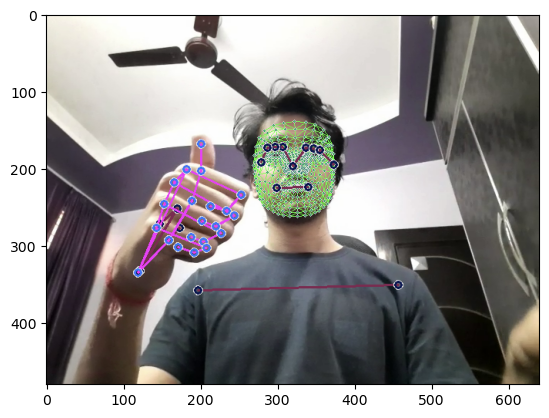

In [7]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

### Extract Detected Keypoints

In [8]:
def extract_keypoints(results):    #grabbing all the keypoint data and converting it into a flatten array for LSTM model input
    #pose landmarks extraction
    if(results.pose_landmarks):
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
    else:
        pose = np.zeros(33*4)
    #Face landmarks extraction
    if(results.face_landmarks):
        face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
    else:
        face = np.zeros(468*3)
    #left hand landmarks extraction
    if(results.left_hand_landmarks):
        left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        left_hand = np.zeros(21*3) 
    #right hand landmarks extraction
    if(results.right_hand_landmarks):
        right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        right_hand = np.zeros(21*3)
        
    return np.concatenate([pose,face,left_hand,right_hand])

In [9]:
extract_keypoints(results)[:10]

array([ 0.50028515,  0.41068876, -0.72257984,  0.99999869,  0.52753067,
        0.36080518, -0.65528142,  0.9999963 ,  0.5428884 ,  0.36373854])

### Data Collection Setup

In [10]:
DATA_PATH = os.path.join('ActionDetection_Data')  #Path to export data in form of numpy arrays

actions = np.array(['Hello', 'Nice', 'Victory'])  #Goal : Actions to detect

no_sequences = 30  #30 videos

sequence_length = 30  #Length of each sequence 30 frames

In [11]:
for action in actions:                                  #Loop through all actions
    for sequence in range(no_sequences):                #Create folder for each sequence per action
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### Keypoints Collection for Training and Testing

In [12]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    
    # Loop through actions
    for action in actions:
        # Loop through sequences
        for sequence in range(no_sequences):
            # Loop through video length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                

                # Draw landmarks
                draw_landmarks(image, results)
                
                # Collecting data
                # Pause at first frame
                if frame_num == 0: 
                    # Text display for capturing instructions
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Camera Input', image)
                    # 1 second delay
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Camera Input', image)
                
                # Extract keypoints
                keypoints = extract_keypoints(results)
                # Path setup
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                # Saving each sequence as numpy array
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

### Data Preprocessing and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split                   #to split data into training and testing sets
from tensorflow.keras.utils import to_categorical                      #convert categorical data into one-hot encoded data

In [17]:
label_map = {label:num for num, label in enumerate(actions)}

In [18]:
label_map

{'Hello': 0, 'Nice': 1, 'Victory': 2}

In [19]:
sequences, labels= [],[]

#going through each actions
for action in actions:
    #Each video per action
    for sequence in range(no_sequences):
        window=[] #list for current video
        
        #going through each frame
        for frame in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f'{frame}.npy')) #load each numpy array of detected keypoints 
            window.append(res)                                                            #append with current list
        sequences.append(window) #append final list of all videos per action
        labels.append(label_map[action]) #append respective action label for actual output

In [22]:
np.array(sequences).shape #90 videos[3 action with 30 videos] 30 frames each with 1662 keypoints per frame

(90, 30, 1662)

In [23]:
np.array(labels).shape

(90,)

In [24]:
X = np.array(sequences)

In [25]:
X.shape

(90, 30, 1662)

In [29]:
y = to_categorical(labels).astype(int) #one-hot encoding

In [ ]:
y

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) #splitting data

In [35]:
X_test.shape

(5, 30, 1662)

### Build and Train LSTM neural network

In [38]:
from tensorflow.keras.models import Sequential               #Connect layers
from tensorflow.keras.layers import LSTM, Dense              #Create layers
from tensorflow.keras.callbacks import TensorBoard           #Monitor model while training

In [39]:
log_dir = os.path.join('Logs')                               #Directory path for logging
tb_callback = TensorBoard(log_dir = log_dir)

In [40]:
#creating model
model = Sequential()
model.add(LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30,1662)))   #LSTM layer with 64 nodes, takes input(30,1662) ie Shape of a video(30 frames), return_sequence for next LSTM layer
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(LSTM(64, return_sequences = False, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))   #Output layer for each action (0,1,2) with softmax action

In [41]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])          #multiclass-classification loss function

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

### Make Predictions

In [45]:
res = model.predict(X_test)

1/1 [==============================] - 0s 240ms/step


In [51]:
actions[np.argmax(res[4])]

'Nice'

In [52]:
actions[np.argmax(y_test[4])]

'Nice'

### Save Trained Model Weights

In [53]:
model.save('sign_detection.h5')

In [55]:
#model.load_weights('sign_detection.h5')

### Model Evaluation using Confusion Matrix and Accuracy

In [56]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [61]:
yhat = model.predict(X_test)      #predictions on test data

1/1 [==============================] - 0s 30ms/step


In [62]:
yhat = np.argmax(yhat, axis=1).tolist()   #convert into labels using argmax

In [65]:
ytrue = np.argmax(y_test, axis=1).tolist() #expected output

In [66]:
ytrue

[1, 2, 2, 0, 1]

In [67]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]]], dtype=int64)

In [68]:
accuracy_score(ytrue, yhat)

1.0

In [69]:
#trying out on training data
yhat1 = model.predict(X_train)
yhat1 = np.argmax(yhat1, axis=1).tolist()
ytrue1 = np.argmax(y_train, axis=1).tolist()

3/3 [==============================] - 0s 30ms/step


In [70]:
multilabel_confusion_matrix(ytrue1, yhat1)

array([[[50,  6],
        [ 0, 29]],

       [[57,  0],
        [ 0, 28]],

       [[57,  0],
        [ 6, 22]]], dtype=int64)

In [71]:
accuracy_score(ytrue1, yhat1)

0.9294117647058824

### Testing the Model in Real-time

In [73]:
colors = [(245,117,16), (117,245,16), (16,117,245)] #color for each action label
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)                             #dynamic coloured rectangle using prediction score
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA) 
        
    return output_frame

In [ ]:
#1:Variables for prediction
sequence = []  #to capture 30 frames of data
sentence = []  #append predictions to form sentence
predictions = []
threshold = 0.8  #for prediction
cap = cv2.VideoCapture(0) #Connecting webcam
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:  #Setup mediapipe model
    while cap.isOpened(): #loop when the device is connected
        ret, frame = cap.read() #reading and storing frames
    
        image, results = mediapipe_detection(frame,holistic)  #make detections per frame by passing loaded mediapipe model
        print(results)
        
        draw_landmarks(image,results)  #To draw landmarks in real time
        
        #2:making predictions
        keypoints = extract_keypoints(results) 
        sequence.append(keypoints)   #appending per frame
        sequence = sequence[-30:]    #grabbing last 30 frames to create single sequence/video 
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #model expects (1,30,1662) but sequence is (30,1662)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3:Visualization
            if np.unique(predictions[-10:])[0]==np.argmax(res):                    #findind unique predictions from the last 10 predictions to avoid error between transtion from one action to another
                if res[np.argmax(res)] > threshold:                                #Extracting prediction probability of the predicted action
                        if len(sentence) > 0:                                      #if sentence already has prediction
                            if actions[np.argmax(res)] != sentence[-1]:            #check if it is same as current prediction
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])               #if none predictions then append current

            if len(sentence) > 5: 
                sentence = sentence[-5:]                                           #grab last 5 predictions
        
        #4:Visualize probabilities            
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)                 #create rectangle above camera feed
        cv2.putText(image, ' '.join(sentence), (3,30),                             #show relevant output
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)    
    
        cv2.imshow('Camera input', image)                                          #Output of landmarked image
    
        if cv2.waitKey(10) & 0xFF == ord('q'):                                     #Break connection Hotkey=q
            break
    cap.release()
    cv2.destroyAllWindows()